# Brain Tumor Detection Using CNN

### Importing Modules

In [2]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Input, ZeroPadding2D, BatchNormalization, Activation, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
import cv2
import imutils
import numpy as np
import matplotlib.pyplot as plt
import time
from os import listdir

#### Data Preparation & Data Preprocessing

We employed a cropping technique to determine the extreme top, bottom, left, and right points of the brain in order to crop the section of the image that only contains the brain. You can discover more about it by visiting here.(https://www.pyimagesearch.com/2016/04/11/finding-extreme-points-in-contours-with-opencv/).

In [3]:
def crop_brain_contour(image, plot=False):
    #import imutils
    #import cv2
    #from matplotlib import pyplot as plt
    # Convert the image to grayscale, and blur it slightly
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)
    # Threshold the image, then perform a series of erosions +
    # dilations to remove any small regions of noise
    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)

    # Find contours in thresholded image, then grab the largest one
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)
    
    # Find the extreme points
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])
    
    # crop new image out of the original image using the four extreme points (left, right, top, bottom)
    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]            

    if plot:
        plt.figure()

        plt.subplot(1, 2, 1)
        plt.imshow(image)
        
        plt.tick_params(axis='both', which='both', 
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        
        plt.title('Original Image')
            
        plt.subplot(1, 2, 2)
        plt.imshow(new_image)

        plt.tick_params(axis='both', which='both', 
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)

        plt.title('Cropped Image')
        
        plt.show()

    return new_image

**To verify how the cropping technique worked, follow the example below.**

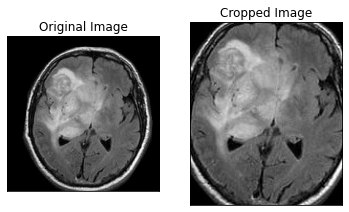

In [4]:
ex_img = cv2.imread('yes/Y2.jpg')
ex_new_img = crop_brain_contour(ex_img, True)

### DATA LOADING

The following function accepts two arguments: the first is a list of directory locations for the image data folders 'yes' and 'no,' and the second is the image size. We read each image and then cropped the portion of the image that represented only the brain. and after that Because the images in the dataset are varied sizes (in terms of width, height, and number of channels), I resized the image. To feed it as an input to the neural network, we want all of our photos to be (240, 240, 3). We then applied normalisation because we wanted the pixel values to be scaled to a range of 0-1. The image was appended to X, and the label was appended to y.After that, Shuffle <i>X</i> and <i>y</i>, because the data is ordered

In [5]:
def load_data(dir_list, image_size):
    # load all images in a directory
    X = []
    y = []
    image_width, image_height = image_size
    
    for directory in dir_list:
        for filename in listdir(directory):
            # load the image
            image = cv2.imread(directory + '\\' + filename)
            # crop the brain and ignore the unnecessary rest part of the image
            image = crop_brain_contour(image, plot=False)
            # resize image
            image = cv2.resize(image, dsize=(image_width, image_height), interpolation=cv2.INTER_CUBIC)
            # normalize values
            image = image / 255.
            # convert image to numpy array and append it to X
            X.append(image)
            # append a value of 1 to the target array if the image
            # is in the folder named 'yes', otherwise append 0.
            if directory[-3:] == 'yes':
                y.append([1])
            else:
                y.append([0])
                
    X = np.array(X)
    y = np.array(y)
    
    # Shuffle the data
    X, y = shuffle(X, y)
    
    print(f'Number of examples is: {len(X)}')
    print(f'X shape is: {X.shape}')
    print(f'y shape is: {y.shape}')
    
    return X, y

In [6]:
augmented_path = 'Final Augmented Data/'

# augmented data (yes and no) contains both the original and the new generated examples
augmented_yes = augmented_path + 'yes' 
augmented_no = augmented_path + 'no'

IMG_WIDTH, IMG_HEIGHT = (240, 240)


In [7]:
X, y = load_data([augmented_yes, augmented_no], (IMG_WIDTH, IMG_HEIGHT))

Number of examples is: 2065
X shape is: (2065, 240, 240, 3)
y shape is: (2065, 1)


### Spliting Data-

Splitting X and y in the training and development, as well as the testing set

In [8]:
X_train, X_test_val, y_train, y_test_val = train_test_split(X, y, test_size=0.2)
X_test, X_val, y_test, y_val = train_test_split(X_test_val, y_test_val, test_size=0.5)

**We splitted the data into three sets: 80% training, 10% development, and 10% testing.**

In [9]:
# function for calculating F1 Score

def compute_f1_score(y_true, prob):
    # convert the vector of probabilities to a target vector
    y_pred = np.where(prob > 0.5, 1, 0)
    score = f1_score(y_true, y_pred)
    return score

In [10]:
# formating time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return f"{h}:{m}:{round(s,1)}"

## Building Model Using CNN

In [11]:
def build_model(input_shape):
  
    # Define the input placeholder as a tensor with shape input_shape. 
    X_input = Input(input_shape) # shape=(?, 240, 240, 3)
    
    # Zero-Padding: pads the border of X_input with zeroes
    X = ZeroPadding2D((2, 2))(X_input) # shape=(?, 244, 244, 3)
    
    # CONV -> BN -> RELU Block applied to X
    X = Conv2D(32, (7, 7), strides = (1, 1), name = 'conv0')(X)
    X = BatchNormalization(axis = 3, name = 'bn0')(X)
    X = Activation('relu')(X) # shape=(?, 238, 238, 32)
    
    # MAXPOOL
    X = MaxPooling2D((4, 4), name='max_pool0')(X) # shape=(?, 59, 59, 32) 
    
    # MAXPOOL
    X = MaxPooling2D((4, 4), name='max_pool1')(X) # shape=(?, 14, 14, 32)
    
    # FLATTEN X 
    X = Flatten()(X) # shape=(?, 6272)
    # FULLYCONNECTED
    X = Dense(1, activation='sigmoid', name='fc')(X) # shape=(?, 1)
    
    # Create model. This creates your Keras model instance, you'll use this instance to train/test the model.
    model = Model(inputs = X_input, outputs = X, name='BrainDetectionModel')
    
    return model

In [12]:
# Defining image shape

IMG_SHAPE = (IMG_WIDTH, IMG_HEIGHT, 3)

In [13]:
model= build_model(IMG_SHAPE)

In [14]:
model.summary()

Model: "BrainDetectionModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 240, 240, 3)]     0         
                                                                 
 zero_padding2d (ZeroPadding  (None, 244, 244, 3)      0         
 2D)                                                             
                                                                 
 conv0 (Conv2D)              (None, 238, 238, 32)      4736      
                                                                 
 bn0 (BatchNormalization)    (None, 238, 238, 32)      128       
                                                                 
 activation (Activation)     (None, 238, 238, 32)      0         
                                                                 
 max_pool0 (MaxPooling2D)    (None, 59, 59, 32)        0         
                                               

### Compiling model

In [15]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [16]:
# tensorboard
log_file_name = f'brain_tumor_detection_cnn_{int(time.time())}'
tensorboard = TensorBoard(log_dir=f'logs/{log_file_name}')

In [23]:
# unique file name that will include the epoch and the validation (development) accuracy
filepath="cnn-parameters-improvement-{epoch:02d}-{val_accuracy:.2f}"
# save the model with the best validation (development) accuracy till now
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max'))

### Training model

In [24]:
start_time = time.time()

model.fit(x=X_train, y=y_train, batch_size=32, epochs=10, validation_data=(X_val, y_val), callbacks=[tensorboard, checkpoint])

end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")

Epoch 1/10
52/52 [==============================] - 170s 3s/step - loss: 0.3761 - accuracy: 0.8378 - val_loss: 0.6695 - val_accuracy: 0.5942
Epoch 2/10
52/52 [==============================] - 128s 2s/step - loss: 0.3120 - accuracy: 0.8729 - val_loss: 0.4957 - val_accuracy: 0.7681
Epoch 3/10
52/52 [==============================] - 158s 3s/step - loss: 0.3185 - accuracy: 0.8735 - val_loss: 0.4685 - val_accuracy: 0.7681
Epoch 4/10
52/52 [==============================] - 149s 3s/step - loss: 0.2600 - accuracy: 0.8971 - val_loss: 0.4359 - val_accuracy: 0.8019
Epoch 5/10
52/52 [==============================] - 137s 3s/step - loss: 0.2497 - accuracy: 0.9025 - val_loss: 0.5572 - val_accuracy: 0.7536
Epoch 6/10
52/52 [==============================] - 127s 2s/step - loss: 0.2312 - accuracy: 0.9092 - val_loss: 0.3122 - val_accuracy: 0.8841
Epoch 7/10
52/52 [==============================] - 133s 3s/step - loss: 0.2148 - accuracy: 0.9080 - val_loss: 0.2993 - val_accuracy: 0.8889
Epoch 8/10
52

In [25]:
start_time = time.time()

model.fit(x=X_train, y=y_train, batch_size=32, epochs=5, validation_data=(X_val, y_val), callbacks=[tensorboard, checkpoint])

end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")

Epoch 1/5
52/52 [==============================] - 163s 3s/step - loss: 0.1700 - accuracy: 0.9425 - val_loss: 0.3003 - val_accuracy: 0.8792
Epoch 2/5
52/52 [==============================] - 137s 3s/step - loss: 0.1448 - accuracy: 0.9498 - val_loss: 0.2702 - val_accuracy: 0.8889
Epoch 3/5
52/52 [==============================] - 128s 2s/step - loss: 0.1965 - accuracy: 0.9177 - val_loss: 0.3383 - val_accuracy: 0.8551
Epoch 4/5
52/52 [==============================] - 125s 2s/step - loss: 0.1387 - accuracy: 0.9528 - val_loss: 0.3559 - val_accuracy: 0.8502
Epoch 5/5
52/52 [==============================] - 125s 2s/step - loss: 0.1293 - accuracy: 0.9552 - val_loss: 0.3158 - val_accuracy: 0.8937
Elapsed time: 0:12:59.5


In [26]:
start_time = time.time()

model.fit(x=X_train, y=y_train, batch_size=32, epochs=5, validation_data=(X_val, y_val), callbacks=[tensorboard, checkpoint])

end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")

Epoch 1/5
52/52 [==============================] - 177s 3s/step - loss: 0.1011 - accuracy: 0.9673 - val_loss: 0.3038 - val_accuracy: 0.8841
Epoch 2/5
52/52 [==============================] - 128s 2s/step - loss: 0.0906 - accuracy: 0.9776 - val_loss: 0.2779 - val_accuracy: 0.8841
Epoch 3/5
52/52 [==============================] - 125s 2s/step - loss: 0.0864 - accuracy: 0.9782 - val_loss: 0.3045 - val_accuracy: 0.8792
Epoch 4/5
52/52 [==============================] - 131s 3s/step - loss: 0.0822 - accuracy: 0.9752 - val_loss: 0.3747 - val_accuracy: 0.8841
Epoch 5/5
52/52 [==============================] - 128s 2s/step - loss: 0.0726 - accuracy: 0.9873 - val_loss: 0.2489 - val_accuracy: 0.8937
Elapsed time: 0:14:2.9


In [27]:
history = model.history.history

### Loss Plot and Accuracy Plot

In [28]:
for key in history.keys():
    print(key)

loss
accuracy
val_loss
val_accuracy


In [29]:
def plot_metrics(history):
    
    train_loss = history['loss']
    val_loss = history['val_loss']
    train_acc = history['accuracy']
    val_acc = history['val_accuracy']
    
    # Loss
    plt.figure()
    plt.plot(train_loss, color="green", label='Training Loss')
    plt.plot(val_loss, color="red", label='Validation Loss')
    plt.title('Loss')
    plt.legend()
    plt.show()
    
    # Accuracy
    plt.figure()
    plt.plot(train_acc, color="green", label='Training Accuracy')
    plt.plot(val_acc, color="red", label='Validation Accuracy')
    plt.title('Accuracy')
    plt.legend()
    plt.show()

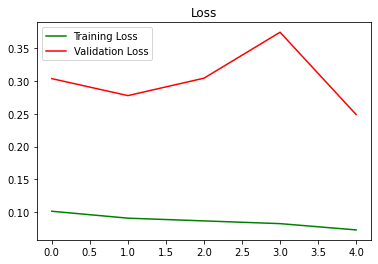

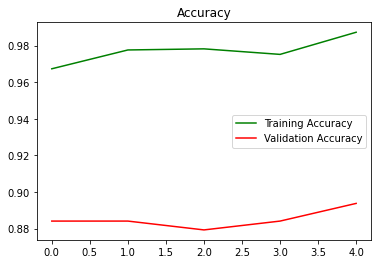

In [30]:
plot_metrics(history)

### Loading best Model

In [42]:
best_model = load_model(filepath='models\cnn-parameters-improvement-05-0.89.model')

In [43]:
best_model.metrics_names

['loss', 'accuracy']

# End Results-

We've loaded the best model, which is on its 20th iteration and has a 90% validation accuracy.

In [44]:
loss, acc = best_model.evaluate(x=X_test, y=y_test)

7/7 [==============================] - 5s 686ms/step - loss: 0.2970 - accuracy: 0.8786


### Chosen model's accuracy on the test dataset,

In [45]:
print (f"Test Loss = {loss}")
print (f"Test Accuracy = {acc}")

Test Loss = 0.29699742794036865
Test Accuracy = 0.8786407709121704


In [46]:
y_test_prob = best_model.predict(X_test)

### Chosen model's F1 score on the testing data,

In [47]:
f1score = compute_f1_score(y_test, y_test_prob)
print(f"F1 score: {f1score}")

F1 score: 0.8847926267281105


In [48]:
y_val_prob = best_model.predict(X_val)

### Chosen model's F1 score on the Validation data,

In [49]:
f1score_val = compute_f1_score(y_val, y_val_prob)
print(f"F1 score: {f1score_val}")

F1 score: 0.9017857142857143


### Standard data interpration-

In [55]:
def data_percentage(y):
    
    m=len(y)
    n_positive = np.sum(y)
    n_negative = m - n_positive
    
    print(f"Number of examples: {m}")
    print(f" number of positive examples: {n_positive}") 
    print(f" number of negative examples: {n_negative}") 


In [56]:
data_percentage(y)

Number of examples: 2065
 number of positive examples: 1085
 number of negative examples: 980


In [57]:
print("Training Data:")
data_percentage(y_train)
print("Development Data:")
data_percentage(y_val)
print("Testing Data:")
data_percentage(y_test)

Training Data:
Number of examples: 1652
 number of positive examples: 872
 number of negative examples: 780
Development Data:
Number of examples: 207
 number of positive examples: 109
 number of negative examples: 98
Testing Data:
Number of examples: 206
 number of positive examples: 104
 number of negative examples: 102


# Conclusion-

##### On test data, our algorithm detects brain tumours with 88% accuracy and an F1 Score of 89%

| <!-- -->  | Validation set | Test set |
| --------- | -------------- | -------- |
| Accuracy  | 89%            | 88%      |
| F1 score  | 0.901          | 0.87     |